# Group 14 - Project FP01
## Time series anomaly detection - Random Forest Classifier

This project aims at investigating the current state-of-the-arts TAD scenario.

In [17]:
# %pip install --no-binary :all: -r requirements.txt

In [18]:
# %pip install numpy==1.26.4
# %pip install pandas==1.5.3
# %pip install tensorflow
# %pip install tsfel
# %pip install keras_tuner
# %pip install -U kaleido
# %pip install seaborn
# %pip install plotly
# %pip install openpyxl

In [19]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner as kt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc

from src.dataset import get_df_action, get_features_ts, get_train_test_data, label_collision_data
from src.plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from src.metrics import Confidence, anomaly_detection_metric, compute_metrics

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [20]:
# from google.colab import drive
# drive.mount('/content/drive')

In [21]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  './dataset/normal' #'/content/drive/MyDrive/dataset/normal'
ROOTDIR_DATASET_ANOMALY = './dataset/collisions'#'/content/drive/MyDrive/dataset/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [22]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)


# COLLISION DATA
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = collision_rec1
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

collisions_adjusted = collisions.Timestamp - pd.to_timedelta([2] * len(collisions.Timestamp), 'h')
# transform in like collision
collisions['Timestamp'] = collisions_adjusted

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [23]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


In [ ]:
X_train, y_train, X_test, y_test, X_test_start_end = get_train_test_data(df_features, df_features_collision)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)


In [ ]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
y_test_collision = df_with_labels["is_collision"]

Trying to take collision_zones



In [ ]:
ts_starts = collisions[collisions['Inizio/fine'] == 'i'].Timestamp.reset_index()
ts_ends = collisions[collisions['Inizio/fine'] == 'f'].Timestamp.reset_index()

d = {'start': ts_starts.Timestamp, 'end': ts_ends.Timestamp}
collision_zones = pd.DataFrame(d)


## Random Forest

In [ ]:
num_estims = [10, 100, 1000]
crits = ['gini', 'entropy', 'log_loss']
max_dept = [None, 50, 100, 1000]
min_s_splits = [2, 3]
max_features = ['sqrt', 'log2', None]

classifier = RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    max_depth = 1000,
    min_samples_split = 2,
    max_features = 'sqrt'
    )
# Train the RandomForestClassifier on normal data
classifier.fit(X_train, y_train)
print("Random Forest training completed.")


Random Forest training completed.


### Anomaly Detection

In [ ]:
anomaly_scores = None
try:
    anomaly_scores = classifier.predict(X_test)
    # Replace inf values with the maximum float value
    anomaly_scores = np.nan_to_num(anomaly_scores, nan=np.nanmean(anomaly_scores), posinf=np.finfo(float).max, neginf=np.finfo(float).min)
except Exception as e:
    print(f"An error occurred during prediction: {str(e)}")
    # If an error occurs, you might want to inspect the model's internal state
print("Anomaly prediction completed.")

Anomaly prediction completed.


In [ ]:
anomaly_scores

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  1,  1, 13,  1,  1,
        1,  1,  1,  1,  1, 26, 26,  2, 26,  6,  2,  2,  2,  2,  3,  3,  4,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, 11,  3,  3,
        3, 11,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
       11, 11, 11, 11,  4,  4,  4,  4,  1, 21,  5,  5,  5, 17, 27,  5,  5,
        6,  6,  6,  6, 22,  8, 10,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  0,  8,  8,  8,  8,  8,  3,  8,  8,  8,  8,  3,  8,  8,  8,  3,
        3, 11,  8,  9,  9,  9,  9,  9,  9, 11,  9, 29, 10, 10, 10, 10, 10,
       10,  6, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12,  0, 12,
       12, 12, 12,  7, 11,  7, 12,  7, 11, 12, 12, 13, 13, 13, 13,  1, 13,
       14, 14, 14,  0,  0, 14, 15, 15, 15, 17,  5, 21, 16, 16, 16, 14, 16,
       16, 17, 17, 17, 17

In [ ]:
threshold_1 = np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)

In [ ]:
median = np.median(anomaly_scores)
mad = np.median(np.abs(anomaly_scores - median))
threshold_2 = median + 3 * mad

In [ ]:
threshold_3 = np.percentile(anomaly_scores, 95)

In [ ]:
Q1 = np.percentile(anomaly_scores, 25)
Q3 = np.percentile(anomaly_scores, 75)
IQR = Q3 - Q1
threshold_4 = Q3 + 1.5 * IQR

In [ ]:
for threshold in [threshold_1, threshold_2, threshold_3, threshold_4]:
    anomalies_detected = sum(anomaly_scores >= threshold)
    print(f"Number of anomalies detected: {anomalies_detected} with threshold {threshold}")

Number of anomalies detected: 15 with threshold 27.593869077010503
Number of anomalies detected: 25 with threshold 26.0
Number of anomalies detected: 21 with threshold 27.0
Number of anomalies detected: 0 with threshold 34.0


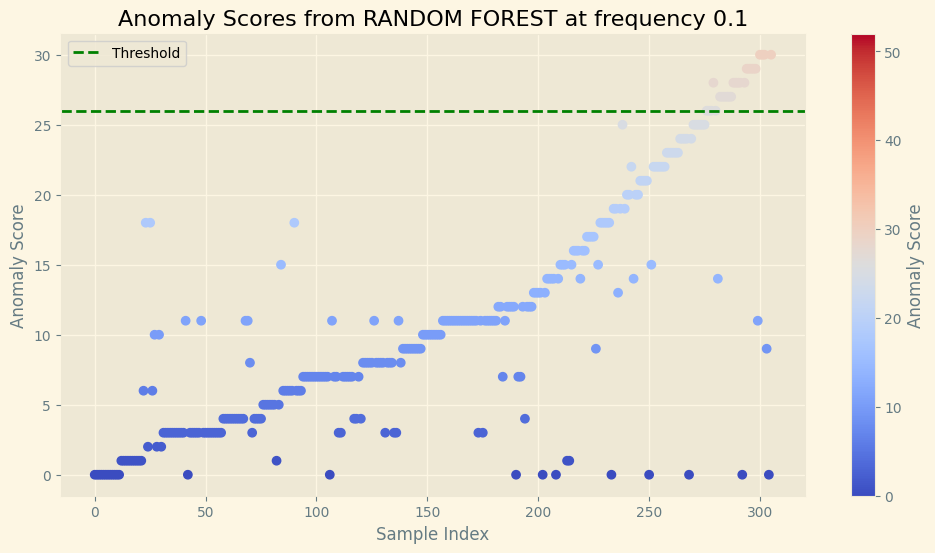

Number of anomalies detected: 21


In [ ]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, threshold_2, "RANDOM FOREST")

In [ ]:
# for classifier in fitted_clfs:
#   print("-------------------------------------------- New classifier --------------------------------------------")
compute_metrics(anomaly_scores, y_test_collision, threshold_2)

ROC AUC Score: 0.5501
Detected anomaly class: 1
Threshold: 26.0000
F1 Score: 0.2000
Accuracy: 0.8170
Precision: 0.3333
Recall: 0.1429
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       257
           1       0.33      0.14      0.20        49

    accuracy                           0.82       306
   macro avg       0.59      0.54      0.55       306
weighted avg       0.77      0.82      0.79       306



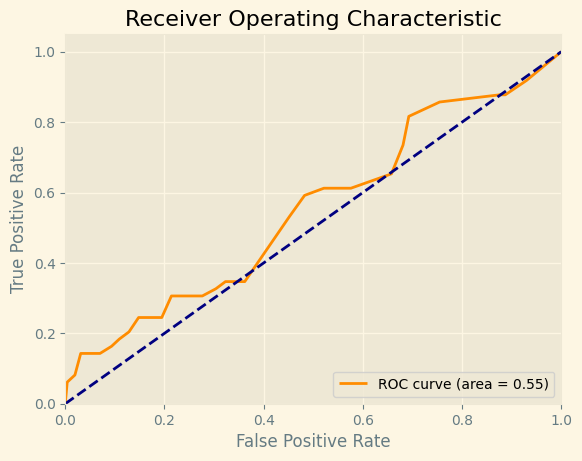

In [ ]:
plot_roc_curve(y_test_collision.values, anomaly_scores)

## Map anomalies to original time series

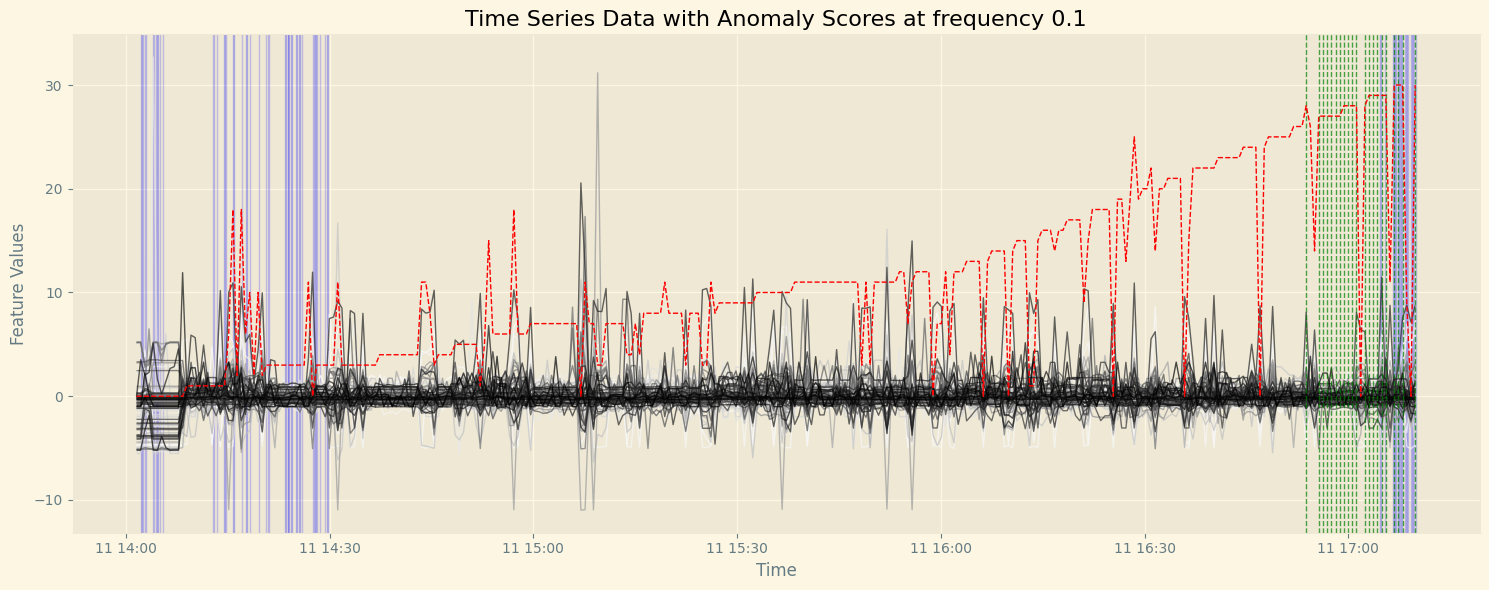

Top 21 Anomalies:
                        timestamp  anomaly_score  \
300 2022-08-11 17:06:45.485311475             30   
301 2022-08-11 17:07:22.521449180             30   
302 2022-08-11 17:07:59.557586885             30   
305 2022-08-11 17:09:50.666000000             30   
294 2022-08-11 17:03:03.268485245             29   
295 2022-08-11 17:03:40.304622950             29   
296 2022-08-11 17:04:17.340760655             29   
297 2022-08-11 17:04:54.376898360             29   
298 2022-08-11 17:05:31.413036065             29   
279 2022-08-11 16:53:47.726419672             28   
288 2022-08-11 16:59:21.051659016             28   
289 2022-08-11 16:59:58.087796721             28   
290 2022-08-11 17:00:35.123934426             28   
291 2022-08-11 17:01:12.160072131             28   
293 2022-08-11 17:02:26.232347540             28   
282 2022-08-11 16:55:38.834832786             27   
283 2022-08-11 16:56:15.870970491             27   
284 2022-08-11 16:56:52.907108196             

In [21]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq, threshold_2, collision_zones, X_test_start_end)